In [122]:
import pandas as pd
import scrapy
from bs4 import BeautifulSoup
from requests import get
#import urllib
import datetime
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns

Using requests from now on to open urls. Simpler, and blows urllib2 out of the water. Also autodetects encoding to decode the response in unicode. Also far more convenient in error handling. 

Use response.ok to check if returned value. 

In [75]:
data = []
for i in range(2011, 2017):
    for j in range(1,13):
        base_url = "https://www.usclimatedata.com/climate/san-diego/california/united-states/usca0982/"
        full_url = base_url + str(i) + "/" + str(j)
        #print(full_url)
        page = get(full_url)
        #print(page)

        #create soup object with parser
        soup = BeautifulSoup(page.text, 'html.parser')
        #print("TEXT: " + page.text)

        #find elements of table
        table = soup.find_all('table', attrs = {'class': 'daily_climate_table'})
        #find values of table
        #table_body = table[1].find_all('tbody')
        #print(table_body[0])

        #gather all the rows of the table
        #rows = table_body[0].find_all('tr')
        rows = table[1].find_all('tr')

        #for each row in rows
        for row in rows:
            #gather all the elements of each row
            cols = row.find_all('td')
            #strip and get text for each element in the row, creating an array
            cols = [ele.text.strip() for ele in cols]
            #append the array of elements
            data.append([ele for ele in cols if ele])
        
        time.sleep(5)    

#sleep so we don't hurt the website we're pulling data from
#T is trace, meaning light, unmeasurable precipitationd
data

[[],
 ['1 jan 2011', '60.1', '46.9', '0.00', '-', '-'],
 ['2 jan 2011', '59.0', '45.0', '0.24', '-', '-'],
 ['3 jan 2011', '61.0', '54.0', '0.02', '-', '-'],
 ['4 jan 2011', '64.9', '50.0', '0.00', '-', '-'],
 ['5 jan 2011', '68.0', '48.0', '0.00', '-', '-'],
 ['6 jan 2011', '69.1', '48.0', 'T', '-', '-'],
 ['7 jan 2011', '61.0', '52.0', 'T', '-', '-'],
 ['8 jan 2011', '59.0', '50.0', '0.00', '-', '-'],
 ['9 jan 2011', '61.0', '54.0', '0.00', '-', '-'],
 ['10 jan 2011', '62.1', '51.1', '0.00', '-', '-'],
 ['11 jan 2011', '69.1', '48.0', '0.00', '-', '-'],
 ['12 jan 2011', '72.0', '51.1', '0.00', '-', '-'],
 ['13 jan 2011', '72.0', '50.0', '0.00', '-', '-'],
 ['14 jan 2011', '75.0', '51.1', '0.00', '-', '-'],
 ['15 jan 2011', '77.0', '53.1', '0.00', '-', '-'],
 ['16 jan 2011', '78.1', '54.0', '0.00', '-', '-'],
 ['17 jan 2011', '82.0', '55.9', '0.00', '-', '-'],
 ['18 jan 2011', '73.9', '57.9', '0.00', '-', '-'],
 ['19 jan 2011', '61.0', '55.9', '0.00', '-', '-'],
 ['20 jan 2011', '72.0

In [62]:
#parsing data with regex
#regex = r'(\d+ \w{3} \d{6}\.\d{3}\.\d{2}\.\d{2})'
#print(re.findall(regex, table[1].text))

In [116]:
df = pd.DataFrame(data)
df = df.dropna(axis = 0)
df.head(10)

,0,1,2,3,4,5
1,1 jan 2011,60.1,46.9,0.00,-,-
2,2 jan 2011,59.0,45.0,0.24,-,-
3,3 jan 2011,61.0,54.0,0.02,-,-
4,4 jan 2011,64.9,50.0,0.00,-,-
5,5 jan 2011,68.0,48.0,0.00,-,-
6,6 jan 2011,69.1,48.0,T,-,-
7,7 jan 2011,61.0,52.0,T,-,-
8,8 jan 2011,59.0,50.0,0.00,-,-
9,9 jan 2011,61.0,54.0,0.00,-,-
10,10 jan 2011,62.1,51.1,0.00,-,-


#### dropping useless information

Checking to see if San Diego ever had snow in those 6 years

In [117]:
print(df[4].unique(), df[5].unique())

['-' '0.00'] ['-' '0.00']


In [118]:
#drop useless last 2 columns
df = df.drop([4,5], axis = 1)
#rename columns
df.columns = ["Date", "MaxTemp", "MinTemp", "Precipitation"]

Precipitation uses "T", trace, when there is light precipitation but not enough to measure height. Replacing all these values with 1e-3

In [120]:
df.Precipitation.replace(to_replace = "T", value = "0.001", inplace = True)

Let's convert the values to their proper type

In [121]:
df.Date = pd.to_datetime(df.Date)
df.MaxTemp = df.MaxTemp.astype(float)
df.MinTemp = df.MinTemp.astype(float)
df.Precipitation = df.Precipitation.astype(float)

In [123]:
df.get_dtype_counts()

datetime64[ns]    1
float64           3
dtype: int64

#### Plotting precipitation vs time

Text(0, 0.5, 'Inches of precipitation')

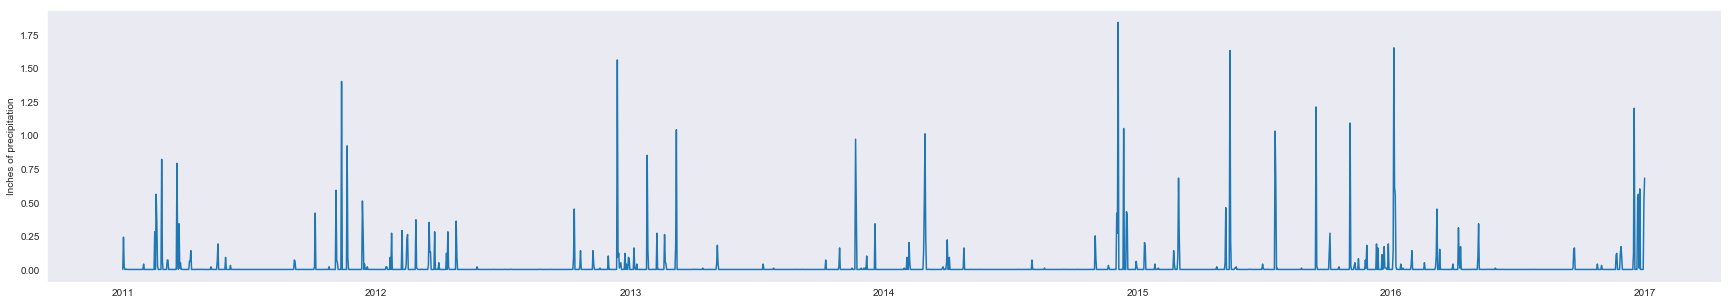

In [131]:
sns.set_style("dark")
plt.figure(figsize = (30, 5))
plt.plot(df.Date, df.Precipitation)
plt.ylabel("Inches of precipitation")

Rain in San Diego seems sparse. Even days with rain have no more than 2 inches. Lets look at the distribution of rain. Most of the days seem to have 0 rain, so lets just look at the dates that do have rain.

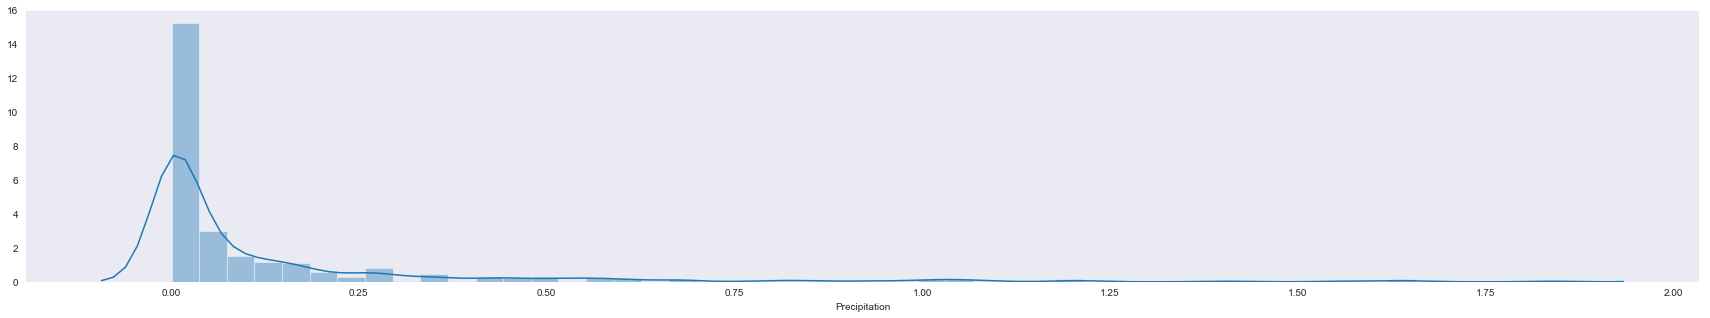

In [163]:
plt.figure(figsize = (30, 5))
sns.distplot(df.Precipitation[df.Precipitation>0], 
    label = "rain",
    #kde_kws = {"lw": 3},
    #hist_kws = {"linewidth": 5,"alpha": .5, }
            )

As expected, the distribution of the rain is predominantly around 0. Trace takes up the most amount of days. If I were to split into categories, I'd probably test the difference between no rain, trace, and any rain

In [165]:
df.to_csv("weather data", sep = ',')